# Model Evaluation

Validate clustering quality and interpret results.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
import sys
sys.path.append('../src')
from clustering import StockClusterer

sns.set_style('whitegrid')

## Load Data and Model

In [5]:
df = pd.read_csv('../Data/Processed/nse_clustered.csv')
clusterer = StockClusterer.load_model('../models/stock_clusterer.pkl')

print(f"Loaded {len(df)} stocks")
print(f"Model uses {len(clusterer.feature_columns)} features")

Model loaded from ../models/stock_clusterer.pkl
Loaded 57 stocks
Model uses 15 features


## Silhouette Analysis

In [6]:
X = df[clusterer.feature_columns].fillna(df[clusterer.feature_columns].median())
X_scaled = clusterer.scaler.transform(X)

avg_silhouette = silhouette_score(X_scaled, df['Cluster'])
print(f"\nSilhouette Score: {avg_silhouette:.3f}")

if avg_silhouette >= 0.5:
    print("✅ EXCELLENT - Well-separated clusters!")
elif avg_silhouette >= 0.4:
    print("✓ GOOD - Clear structure")
elif avg_silhouette >= 0.3:
    print("⚠ MODERATE - Some overlap")
else:
    print("❌ WEAK - Poor separation")


Silhouette Score: 0.708
✅ EXCELLENT - Well-separated clusters!


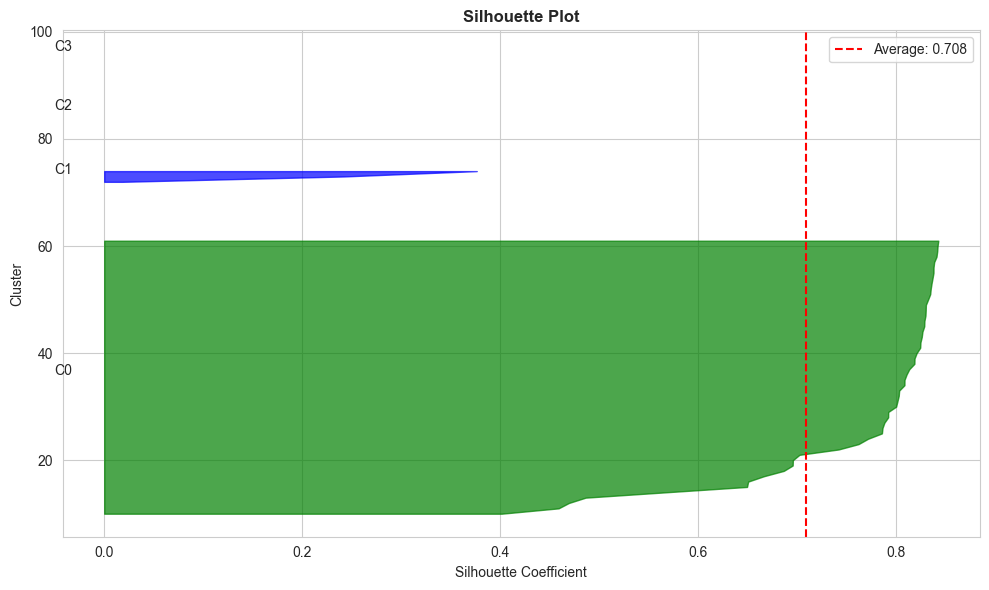

In [7]:
# Per-cluster silhouette
sample_silhouette = silhouette_samples(X_scaled, df['Cluster'])

fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10
colors = ['green', 'blue', 'orange', 'red']

for i in range(4):
    cluster_silhouettes = sample_silhouette[df['Cluster'] == i]
    cluster_silhouettes.sort()
    
    size = cluster_silhouettes.shape[0]
    y_upper = y_lower + size
    
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouettes,
                     facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size, f"C{i}")
    y_lower = y_upper + 10

ax.set_title("Silhouette Plot", fontweight='bold')
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster")
ax.axvline(x=avg_silhouette, color="red", linestyle="--", label=f"Average: {avg_silhouette:.3f}")
ax.legend()
plt.tight_layout()
plt.show()

## Cluster Characteristics

In [8]:
summary = clusterer.get_cluster_summary(df)
print("\nCluster Profiles:")
print(summary)


Cluster Profiles:
                  Count  Avg Volatility  Sharpe Ratio  Avg Drawdown  \
Risk_Profile                                                          
High Risk             1          0.0046        0.8866       -0.0698   
Low Risk             52          0.0272        0.0184       -0.4786   
Medium-High Risk      3          0.0209        0.0140       -0.5520   
Medium-Low Risk       1          0.0222       -0.0102       -0.6376   

                  Trading Freq  Median Volume  
Risk_Profile                                   
High Risk               0.0425     43923.8095  
Low Risk                0.8152     26955.8233  
Medium-High Risk        0.9983    630362.6518  
Medium-Low Risk         1.0000    765106.6802  


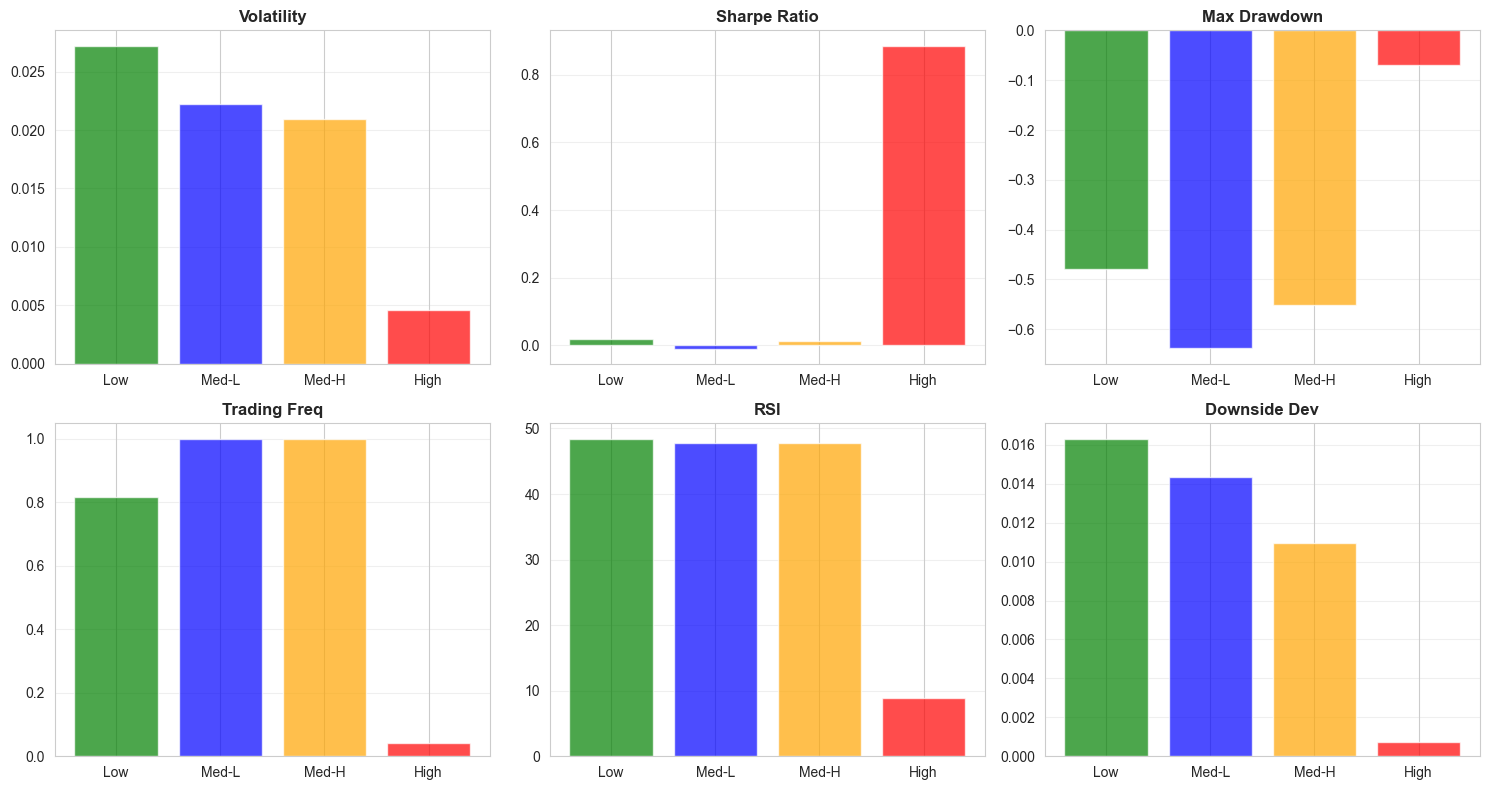

In [9]:
# Visualize profiles
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

metrics = ['volatility_mean', 'sharpe_ratio', 'max_drawdown', 
          'trading_frequency', 'rsi_mean', 'downside_deviation']
titles = ['Volatility', 'Sharpe Ratio', 'Max Drawdown', 
         'Trading Freq', 'RSI', 'Downside Dev']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    if metric in df.columns:
        df_plot = df.groupby('Risk_Profile')[metric].mean().reindex(
            ['Low Risk', 'Medium-Low Risk', 'Medium-High Risk', 'High Risk']
        )
        
        axes[idx].bar(range(len(df_plot)), df_plot.values, 
                     color=['green', 'blue', 'orange', 'red'], alpha=0.7)
        axes[idx].set_title(title, fontweight='bold')
        axes[idx].set_xticks(range(4))
        axes[idx].set_xticklabels(['Low', 'Med-L', 'Med-H', 'High'], rotation=0)
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Sector Distribution


Sector Risk Distribution (%):
Risk_Profile                      Low Risk  Medium-Low Risk  Medium-High Risk  \
Sector                                                                          
Agricultural                         100.0              0.0               0.0   
Automobiles and Accessories          100.0              0.0               0.0   
Banking                               90.9              0.0               9.1   
Commercial and Services              100.0              0.0               0.0   
Construction and Allied              100.0              0.0               0.0   
Energy and Petroleum                  50.0              0.0              50.0   
Exchange Traded Funds                100.0              0.0               0.0   
Insurance                             83.3             16.7               0.0   
Investment                           100.0              0.0               0.0   
Investment Services                  100.0              0.0               0.0 

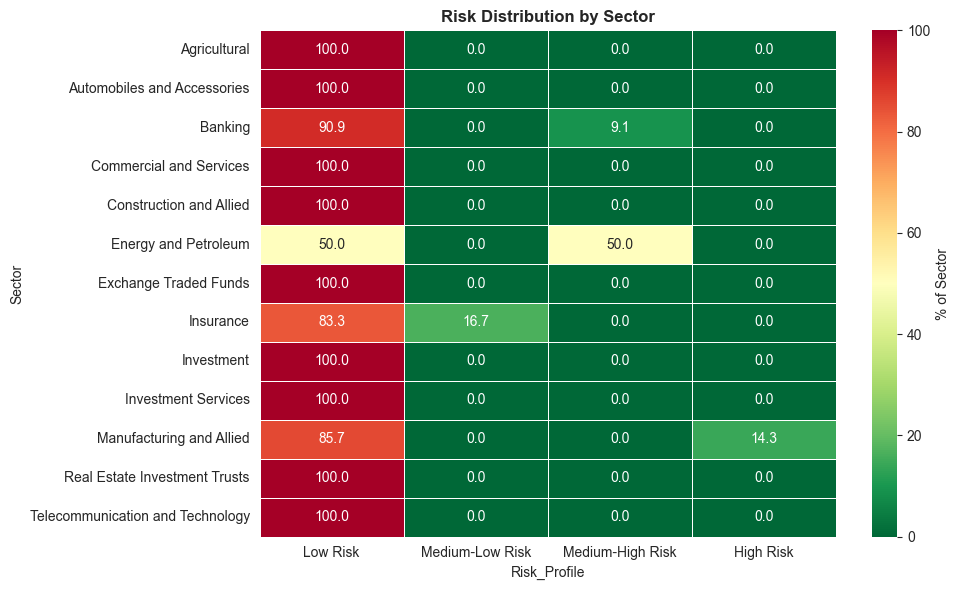

In [10]:
if 'Sector' in df.columns:
    sector_risk = pd.crosstab(df['Sector'], df['Risk_Profile'], normalize='index') * 100
    sector_risk = sector_risk[['Low Risk', 'Medium-Low Risk', 'Medium-High Risk', 'High Risk']]
    
    print("\nSector Risk Distribution (%):")
    print(sector_risk.round(1))
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(sector_risk, annot=True, fmt='.1f', cmap='RdYlGn_r', 
                cbar_kws={'label': '% of Sector'}, linewidths=0.5)
    plt.title('Risk Distribution by Sector', fontweight='bold')
    plt.tight_layout()
    plt.show()

## Feature Importance

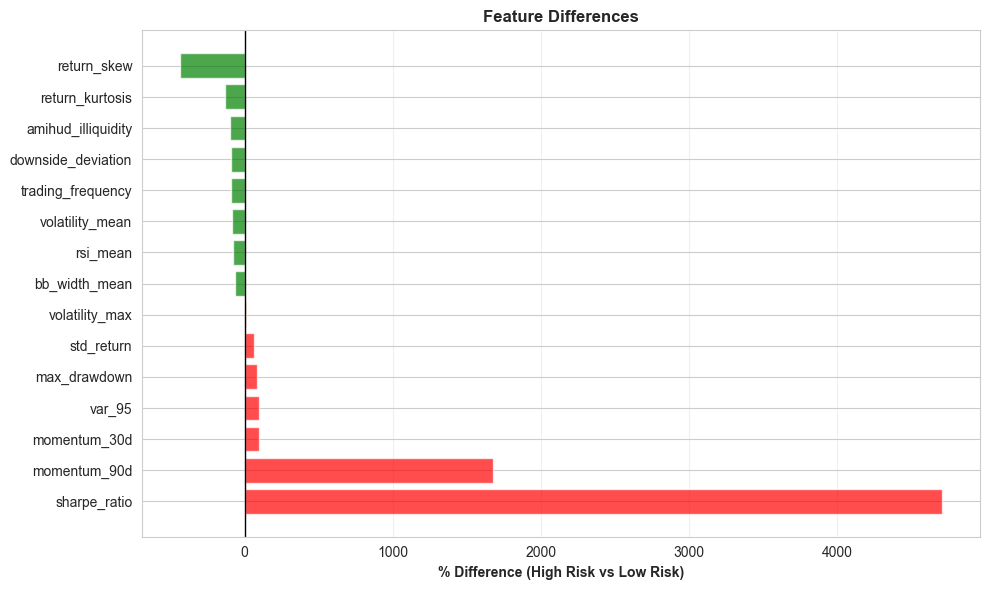


Top 5 Separating Features:
sharpe_ratio    4708.710031
momentum_90d    1676.475616
momentum_30d      99.999971
var_95            99.834162
max_drawdown      85.423425
dtype: float64


In [11]:
# Compare high vs low risk
high_risk = df[df['Risk_Profile'] == 'High Risk'][clusterer.feature_columns].mean()
low_risk = df[df['Risk_Profile'] == 'Low Risk'][clusterer.feature_columns].mean()

diff = ((high_risk - low_risk) / (low_risk.abs() + 1e-10) * 100).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
colors = ['red' if x > 0 else 'green' for x in diff.values]
plt.barh(range(len(diff)), diff.values, color=colors, alpha=0.7)
plt.yticks(range(len(diff)), diff.index)
plt.xlabel('% Difference (High Risk vs Low Risk)', fontweight='bold')
plt.title('Feature Differences', fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 Separating Features:")
print(diff.head(5))